In [3]:
# used libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from scipy.stats import uniform, randint 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc


## Dataset Insights:

* Origin: The data comprises transactions made by European cardholders in September 2013, captured over a span of two days.
* Features: The dataset, veiled in confidentiality, presents numerical variables birthed from a PCA transformation, with the exception of 'Time' and 'Amount' features. The 'Class' feature, our target, flags fraudulent transactions with a 1. Class is perfectly balanced variable.

Modeling with XGBoost:
* Performance: The crux of this endeavor was the crafting of an XGBoost model that astoundingly predicted fraud with a 99% accuracy, a testament to the model's exceptional processing.

Learning and Future Steps:
* Tying Theory to Practice: This project was a practical extension of the theoretical knowledge gained from the book, particularly showcasing the might of XGBoost in tackling real-world, imbalanced data without the necessity of extensive data pre-processing.
* Exploration Ahead: While the current model performs exceptionally, the journey doesn't end here. There's a horizon of exploring other algorithms, tuning model parameters further, and perhaps delving into feature engineering to uncover more.

## Data Inspection Summary
1. V1 - V28 are anynomous features from credit card transactions 
2. Scaling will be required to determine if there are differences between "Amount" and V1-V28 which could generate misleading results during modeling.
3. Class is the dependent variable indicated by a 1 (fraud) or 0 (not fraud).
4. 'id' is the unique transaction identification for each purchase, 'Amount' is the purchase amount. 

In [14]:
cc = pd.read_csv("C:/Users/User/Desktop/learning_archive/ml_keras_tensorflow_scikit_oreily/creditcard_2023.csv")
cc.head()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


Text(0, 0.5, 'Frequency')

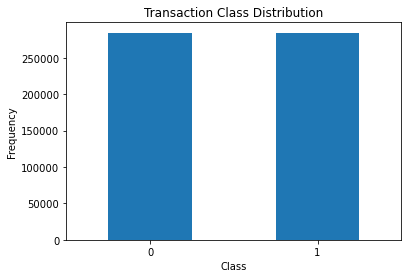

In [19]:
# inspect the dependent "Class" variable
count_classes = pd.value_counts(cc['Class'], sort=True)
count_classes.plot(kind='bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")

## Histogram Interpretation:

* V1 to V28: These are most likely PCA-transformed variables, and many of them appear to be approximately normally distributed. Some of them (V8, V13, V22, V23, and V26) exhibit a narrower range and lower variance compared to others.
* The 'Class' column appear to be approximately even distribution between class '1' (fraud) and '0' (no-fraud). However, I plan to stratify the sample to minimize bias in the underlying prediction
* The 'ID' column is an index column and will be dropped from training and test sets. 
* Finally, I plan to scale the 'Amount' column for use in a logistic regression model to ensure it's on a similar scale as the other independent variables. 

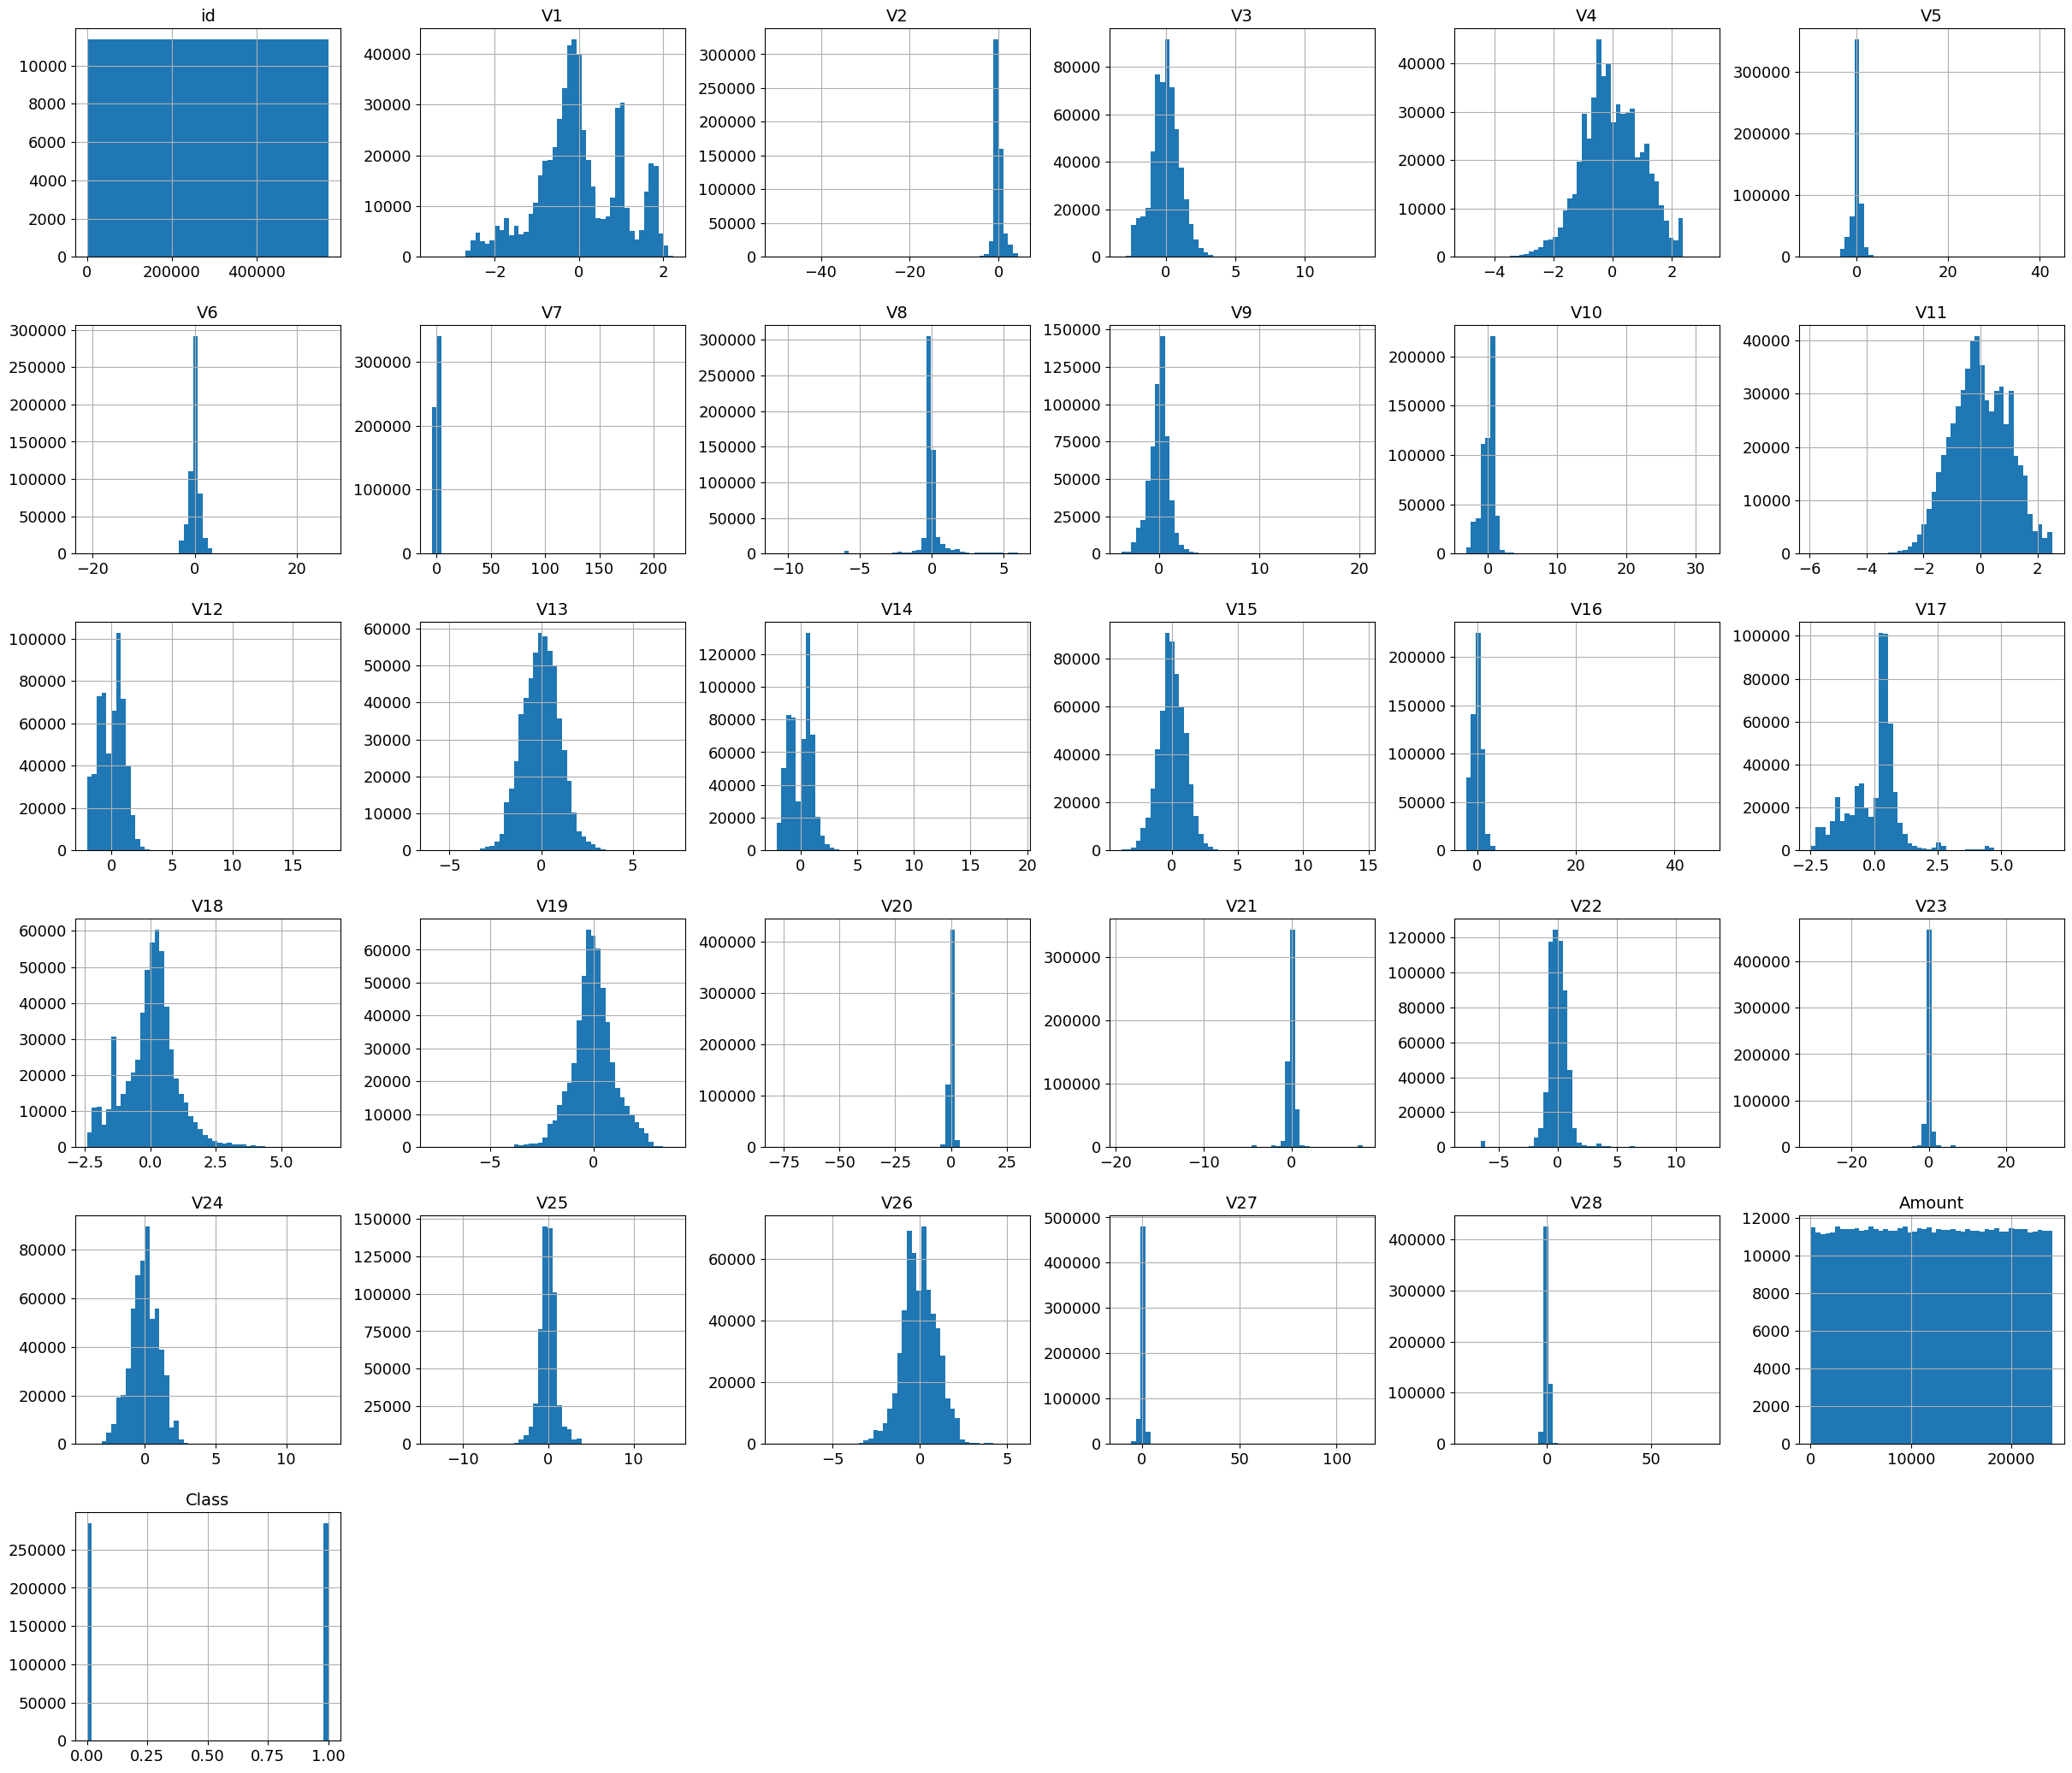

In [3]:
#default labels
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
cc.hist(bins=50, figsize=(30, 26))
plt.grid(False)

## Scale the Amount Column:
* I decided to scale the "Amount" column however, it did not make a difference in importance when using the logistic regression model. 
* I decided to drop Amount from the training and test set due to a very low variable importance score relative other variables.

(array([19005., 18648., 18642., 19195., 19043., 19033., 18915., 19147.,
        18983., 18957., 18891., 19275., 18893., 18990., 19059., 18867.,
        18899., 19099., 18961., 18910., 18812., 18930., 19027., 18897.,
        18932., 18896., 19151., 18755., 18935., 18883.]),
 array([-1.73303098e+00, -1.61746656e+00, -1.50190214e+00, -1.38633771e+00,
        -1.27077329e+00, -1.15520887e+00, -1.03964445e+00, -9.24080031e-01,
        -8.08515610e-01, -6.92951189e-01, -5.77386768e-01, -4.61822348e-01,
        -3.46257927e-01, -2.30693506e-01, -1.15129085e-01,  4.35335673e-04,
         1.15999757e-01,  2.31564177e-01,  3.47128598e-01,  4.62693019e-01,
         5.78257440e-01,  6.93821861e-01,  8.09386281e-01,  9.24950702e-01,
         1.04051512e+00,  1.15607954e+00,  1.27164396e+00,  1.38720839e+00,
         1.50277281e+00,  1.61833723e+00,  1.73390165e+00]),
 <BarContainer object of 30 artists>)

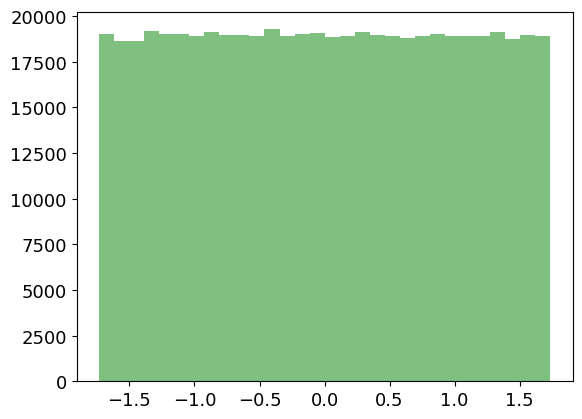

In [4]:
scaler = StandardScaler()
cc['Amount'] = scaler.fit_transform(cc[['Amount']])
cc.head()
color="green"
plt.hist(cc['Amount'], bins=30, alpha=0.5, color=color)

## Stratified Sample by "Class"
* I set my seed to '42' and took a stratified sample for both the training and test sets. 
* There is an exact 50/50 split in the training and test set which will ensure the model accuracy are not biased by an over representation in the Class.

In [5]:
# split into train and test set using 80% / 20%
strat_train_set, strat_test_set = train_test_split(
    cc, test_size=0.2, stratify=cc["Class"], random_state=42)

# check dimensions, NAs, duplicates, and stratified sample
print("////// Train Set ////////")
print("train_set:",strat_train_set.shape)
print("train_set duplicates:", strat_train_set.duplicated().sum())
print("train_set missing values:", strat_train_set.isna().sum().sum())
print("train_set 'Class' count:", strat_train_set['Class'].value_counts().to_dict())
print("////// Test Set ////////")
print("test_set:",strat_test_set.shape)
print("test_set missing values:", strat_test_set.isna().sum().sum())
print("test_set duplicates:", strat_test_set.duplicated().sum())
print("test_set 'Class' count:", strat_test_set['Class'].value_counts().to_dict())

////// Train Set ////////
train_set: (454904, 31)
train_set duplicates: 0
train_set missing values: 0
train_set 'Class' count: {0: 227452, 1: 227452}
////// Test Set ////////
test_set: (113726, 31)
test_set missing values: 0
test_set duplicates: 0
test_set 'Class' count: {1: 56863, 0: 56863}


## Correlation as an Indicator of Variable Importance
* Based on the correlation matrix, I expect V14 (strong negative correlation) means that as V14 increases, the chances of fraud decreases. 
* Whereas V4 has a strong positive correlation, meaning that as V4 increases the probability of fraud (Class = 1) increases.
* V21, V8, V28 appear to have little to no correlation. However, that does mean the variables aren't important.

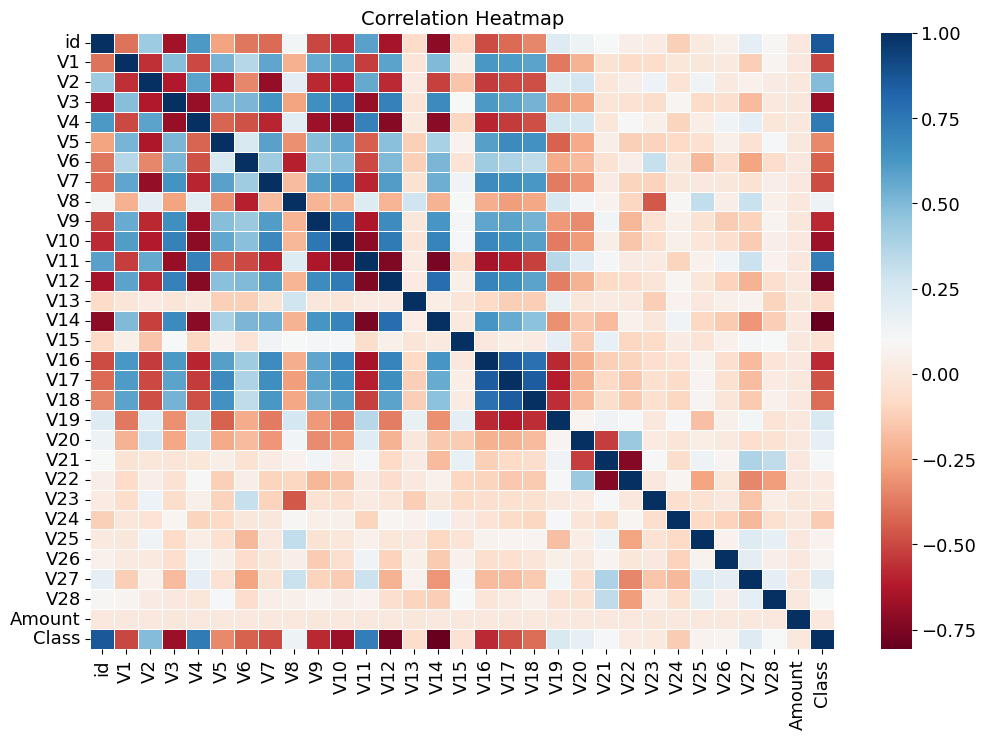

In [6]:
correlation_matrix = cc.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='RdBu', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

## Use Logistic Regression to Drop Variables With Low Importance (Coefficient)
* I used logistic regression to determine variable importance and drop those variables with low variable importance (near 0) represented as coefficients.
* I also dropped the dependent variable "Class" and the index "id" from the dataframe for modeling purposes.

In [9]:
X_train = strat_train_set.drop(["Class", "id", "Amount", "V5", "V13"], axis=1)
y_train = strat_train_set["Class"].copy()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

## Model 1: Logistic Regression
* I re-ran my logistic regression model to examine the new coefficients using 5-fold cross validation. 
* The 5-fold CV accuracy was 96.5% which is relatively high. However, the model still missed 1,271 actual fraud cases.
* I will try a more sophisticated model (XGBoost) to see if I can improve the model Sensitivity (or true positive) rate. 

Cross-validation scores: [0.96328904 0.9656192  0.96558622 0.96521252 0.96531106]
Average cross-validation score: 0.9650036058321131
Standard deviation: 0.0008713556033772196
Intercept as Probability: 0.9998962420261064


Text(0.5, 1.0, 'Feature Coefficients')

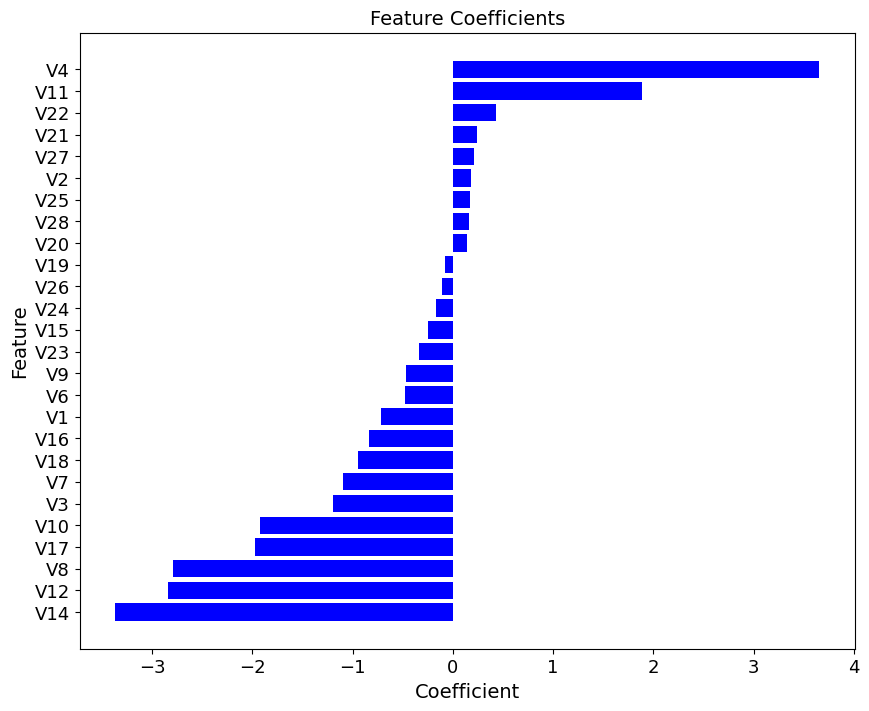

In [10]:
logreg = LogisticRegression().fit(X_train, y_train)
scores = cross_val_score(logreg, X_train, y_train, cv=5)

coefficients = logreg.coef_.flatten()
features = list(X_train.columns)
intercept = logreg.intercept_

coefs = pd.DataFrame({'Feature': features, 
                   'Coefficient': coefficients})

print("Cross-validation scores:", scores)
print("Average cross-validation score:", np.mean(scores))
print("Standard deviation:", np.std(scores))

print(f'Intercept as Probability: {1 / (1 + math.exp(-intercept))}')

plt.figure(figsize=(10, 8))
coefs = coefs.sort_values('Coefficient')
plt.barh(coefs['Feature'], coefs['Coefficient'], color='blue')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Feature Coefficients')

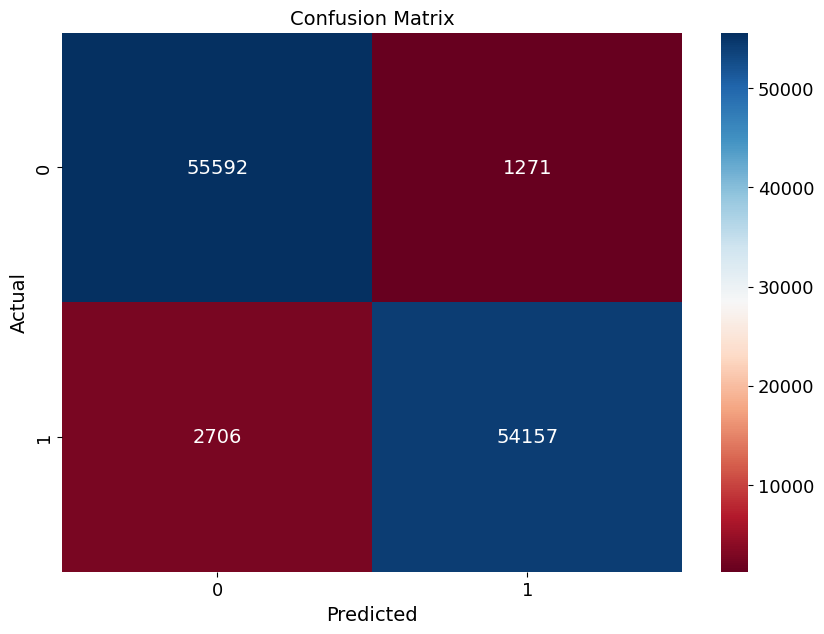

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     56863
           1       0.98      0.95      0.96     56863

    accuracy                           0.97    113726
   macro avg       0.97      0.97      0.97    113726
weighted avg       0.97      0.97      0.97    113726

Accuracy: 0.965029984348346


In [23]:
# Logistic Regression on Test Set
X_test = strat_test_set.drop(["Class", "id", "Amount", "V5", "V13"], axis=1)
y_test = strat_test_set["Class"].copy()

# Make predictions on the test data
y_pred_logreg = logreg.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_logreg)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="RdBu")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report precision, recall, f1-score
print("Classification Report:")
print(classification_report(y_test, y_pred_logreg))

# Model accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg)}")

## Model 2: Xtreme Gradient Boosting (XGBoost)
* XGBoost training time was significantly longer than my logistic model (~15mins) however, the predictive results are impressive with a 99% cross-validated accuracy score!
* I tuned the hyperparameters using RandomizedSearchCV which runs much faster than GridSearchCV and still produces a robust model by searching from a fixed number of parameter settings. 
* The random_search produces 15 total models with 3 random combinations of hyperparameters, crossvalidated 5 total times. 
* I then used best_estimator_ to select the model with the highest mean accuracy score during the cross validation process and applied it to the test set. 


In [21]:
# Define the parameter grid
param_dist = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(3, 6),
    'colsample_bytree': uniform(0.5, 0.5) 
}

# Create the XGBClassifier with the early_stopping_rounds and eval_metric parameters
xgb_clf = XGBClassifier(random_state=0, n_jobs=-1, use_label_encoder=False, 
                        early_stopping_rounds=10, eval_metric="logloss", verbosity=0)

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=xgb_clf, param_distributions=param_dist, 
                                   n_iter=3, cv=5, n_jobs=-1, random_state=0)

# Fit the RandomizedSearchCV object to the data without the deprecated parameters
random_search.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# Get the best model
best_model = random_search.best_estimator_

# Evaluate the best model with the test data and print the score
score = best_model.score(X_test, y_test)
print(f"Test Score with Best Model: {score}")

# Generate predictions on the test set
y_pred_xgb = best_model.predict(X_test)

Test Score with Best Model: 0.9911717637127834


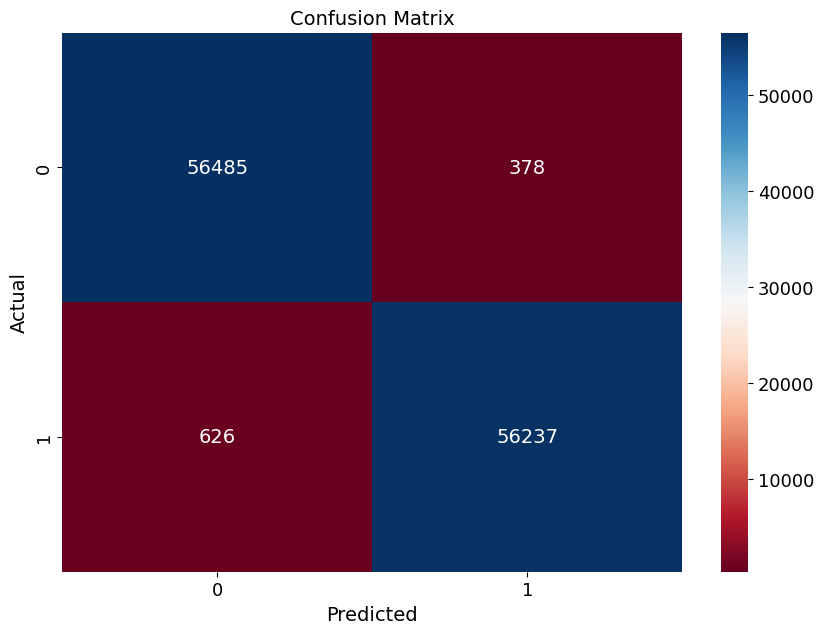

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     56863
           1       0.99      0.99      0.99     56863

    accuracy                           0.99    113726
   macro avg       0.99      0.99      0.99    113726
weighted avg       0.99      0.99      0.99    113726

Accuracy: 0.9911717637127834


In [22]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="RdBu")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report precision, recall, f1-score
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# Model accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb)}")